# Calib

In [9]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import json
import numpy as np
import numpy as np
import time
import math
from ahrs.filters import EKF as ahrsEKF
import ahrs

import busio
import adafruit_bno08x
from adafruit_bno08x.i2c import BNO08X_I2C
from adafruit_bno08x import BNO_REPORT_ACCELEROMETER, BNO_REPORT_GYROSCOPE, BNO_REPORT_ROTATION_VECTOR

from imu_bno import Imu
from math import sqrt, atan2, pi

In [14]:
def get_accel_data(dev):
    acx, acy, acz = dev.acceleration
    return {"x": acx, "y": acy, "z": acz}
def get_gyro_data(dev):
    gx, gy, gz = dev.gyro
    return {"x": gx, "y": gy, "z": gz}
def record(d_s = 80, bltin=False):
    data = []
    data_bltin = None
    i2c = busio.I2C((1, 14), (1, 15))
    bno = Imu(i2c, address=0x4b)
    if bltin:
        bno.enable_feature(BNO_REPORT_ROTATION_VECTOR)
        data_bltin = []
    start = time.time()
    cur = time.time()
    while cur - start < d_s:
        t1 = time.time()
        a = get_accel_data(bno)
        g = get_gyro_data(bno)
        if bltin:
            q = bno.quaternion
            while sqrt(q[0] * q[0] + q[1] * q[1] + q[2] * q[2] + q[3] * q[3]) == 0:
                q = bno.quaternion
            data_bltin.append((q[3], q[0], q[1], q[2]))
        t2 = time.time()
        cur = (t1 + t2)/2
        data.append([cur, {"a": a, "g": g}])
    return data, data_bltin

def deg2rad(dat):
    return {'x': np.deg2rad(dat['x']), 'y': np.deg2rad(dat['y']), 'z': np.deg2rad(dat['z'])}
def dict2arr(dat):
    return [dat['x'], dat['y'], dat['z']]

def q2angles(qs):
    angles = []
    for q in qs:

        rm = ahrs.common.orientation.q2R(q)
        roll = math.atan2(rm[2][1],rm[2][2]);#-math.asin(rm[0][2])
        pitch = math.atan2(-rm[2][0], math.sqrt(rm[2][1]**2 + rm[2][2]**2))#math.atan2(-rm[1][2], rm[2][2])
        
        angles.append({'pitch': math.degrees(pitch), 'roll': math.degrees(roll)}) 
    return angles

# def q2angles(self, Q):
#         dqw, dqx, dqy, dqz = Q
#         norm = math.sqrt(dqw * dqw + dqx * dqx + dqy * dqy + dqz * dqz)
#         dqw = dqw / norm
#         dqx = dqx / norm
#         dqy = dqy / norm
#         dqz = dqz / norm
#         sinr_cosp = +2.0 * (dqw * dqx + dqy * dqz)
#         cosr_cosp = +1.0 - 2.0 * (dqx * dqx + dqy * dqy)
#         roll_raw = math.atan2(sinr_cosp, cosr_cosp)
#         sinp = math.sqrt(+1.0 + 2.0 * (dqw * dqy - dqx * dqz))
#         cosp = math.sqrt(+1.0 - 2.0 * (dqw * dqy - dqx * dqz))
#         pitch_raw = +2.0 * math.atan2(sinp, cosp) - (math.pi / 2.0)
#         ysqr = dqy * dqy
#         t3 = +2.0 * (dqw * dqz + dqx * dqy)
#         t4 = +1.0 - 2.0 * (ysqr + dqz * dqz)
#         yaw_raw = math.atan2(t3, t4)
#         return roll_raw, pitch_raw, yaw_raw
    

In [15]:
def plot_angles(x, angles, title):
    # figure = plt.figure(figsize= (10, 5))

    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize= (10, 5))
    fig.suptitle(title)
    yk = ['roll', 'pitch']
    clrs = ['c', 'm']
    x_label = "time, s"
    y_label = "degrees"
    s_titles = ["Roll", "Pitch"]

    for i in range(2):
        axs[i].plot(x, [el[yk[i]] for el in angles], clrs[i])
        axs[i].set_title(s_titles[i])
        axs[i].set_xlabel(x_label)
        axs[i].set_ylabel(y_label)
        axs[i].plot(x, [0] * len(x), 'black')
    plt.show()

    for k in ['roll', 'pitch']:
        print(f"Avg {k}: ", "%.5lf" % (sum([el[k] for el in angles])/len(x)))
        print(f"Std {k}: ", "%.5lf" % np.std([el[k] for el in angles]), "\n")

def multiplot_angles(x, angles_n, titles):
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize= (10, 5))
    # fig.suptitle(title)
    yk = ['roll', 'pitch']
    clrs = ['c', 'm', 'r', 'g', 'b', 'pink']
    # print(clrs)
    x_label = "time, s"
    y_label = "degrees"
    s_titles = ["Roll", "Pitch"]

    for i, angles in enumerate(angles_n):
        for j in range(2):
            # print(titles[i])
            if j == 0:
                axs[j].plot(x, [el[yk[j]] for el in angles], clrs[i % len(clrs)], label = titles[i])
            else:
                axs[j].plot(x, [el[yk[j]] for el in angles], clrs[i % len(clrs)])
            if i == (len(angles_n) - 1):
                axs[j].set_title(s_titles[j])
                axs[j].set_xlabel(x_label)
                axs[j].set_ylabel(y_label)
                axs[j].plot(x, [0] * len(x), 'black')
            # _patch = mpatches.Patch(color=clrs[j][i mod len(clrs[0])], label=titles[i])
            # axs[j].legend(handles=[red_patch])
    fig.legend(loc='outside upper right')
    plt.show()

def apply_ekf(x, y, avgt, frame="ENU", noises=[0.5, 0.2, 0.8**2]):
    ekf = ahrsEKF(q0 = np.tile([1., 0., 0., 0.], (1)), Dt = avgt, frequancy= avgt ** (-1),
                        gyr= np.array([dict2arr(t['g']) for t in y]), 
                        acc = np.array([dict2arr(t['a']) for t in y]),
                       frame = frame, noises = noises)
    angles = q2angles(ekf.Q)
    plot_angles(x, angles, f"EKF, frame = {frame}, noises = {str(noises)}")
    return angles, "EKF"

def apply_comp(x, y, avgt, alpha=0.5):
    angles = [{'roll': 0., 'pitch': 0}]
    for i in range(1, len(x)):
        # print("ggggg= ", (y[i]['g'])['y'] * avgt)
        pitch = (math.radians(angles[i-1]['pitch']) + deg2rad(y[i]['g'])['y'] * avgt) * alpha + (1 - alpha) * (math.atan(-y[i]['a']['x'] / math.sqrt(y[i]['a']['y'] ** 2 + y[i]['a']['z'] ** 2)))
        roll = (math.radians(angles[i-1]['roll']) + deg2rad(y[i]['g'])['x'] * avgt) * alpha + (1-alpha) * math.atan(y[i]['a']['y'] / math.sqrt(y[i]['a']['x'] ** 2 + y[i]['a']['z'] ** 2))
        angles.append({"roll": math.degrees(roll), "pitch": math.degrees(pitch)})
        # print(angles[i])
    plot_angles(x, angles, f"Простой комплементарный, gain = {alpha}")
    return angles, "Простой комплементарный"

def get_builtin_rpy(x, data):
    angles = q2angles(np.array(data))#[{'roll': 0., 'pitch': 0}]
    # for i in range(1, len(x)):
    #     dw, dx, dy, dz = data[i]
    #     pitch = find_pitch(dw, dx, dy, dz)
    #     roll = find_roll(dw, dx, dy, dz)
    #     angles.append({"roll": roll, "pitch": pitch})
    plot_angles(x, angles, f"Встроенный метод")
    return angles, "Встроенный метод"
def plot_raw(x, y, title):
    fig, axs = plt.subplots(2, 3, constrained_layout=True, figsize= (10, 5))
    ys = [[[el['a']['x'] for el in y], [el['a']['y'] for el in y], [el['a']['z'] for el in y]],
          [[el['g']['x'] for el in y], [el['g']['y'] for el in y], [el['g']['z'] for el in y]]]
    clrs = ['r', 'g', 'b']
    x_label = "время, с"
    y_labels = ["ускорение, м/с^2", "угловая скорость, град/с"]
    s_titles2 = ["X", "Y", "Z"]
    s_titles1 = ["Акселерометр", "Гироскоп"]
    for i in range(2):
        for j in range(3):
            axs[i][j].plot(x, ys[i][j], clrs[j])
            if i == 0 and j == 2:
                axs[i][j].plot(x, [9.8] * len(x), 'black')
            else:
                axs[i][j].plot(x, [0] * len(x), 'black')
            axs[i][j].set_title(s_titles1[i] + ": " + s_titles2[j])
            axs[i][j].set_xlabel(x_label)
            axs[i][j].set_ylabel(y_labels[i])
    fig.suptitle(title)
    plt.show()
    
def process_data(data, title, calib=None, apply_algs=[apply_comp, apply_ekf], dat_bltin=None):
    start = data[0][0]
    x = [el[0] - start for el in data]
    tm = [x[i] - x[i-1] for i in range(1, len(x))]
    avgt = sum(tm)/len(tm)
    print("Avg time between measurements: ", "%.5lfs" % avgt)

    bias = {'a':{'x':0, 'y':0, 'z':9.8}, 'g':{'x':0, 'y':0, 'z':0}}
    d2k = {'acc': 'a', 'gyro': 'g'}
    for device in ['acc', 'gyro']:
        for k in ['x', 'y', 'z']:
            bias[d2k[device]][k] -= sum([el[1][d2k[device]][k] for el in data])/len(x)
            print(f"Avg {device} for {k}: ", "%.4lf" % (sum([el[1][d2k[device]][k] for el in data])/len(x)))
            print(f"Std {device} for {k}: ", "%.4lf" % np.std([el[1][d2k[device]][k] for el in data]), "\n")
            
    plot_raw(x, [el[1] for el in data], title)

    y = [el[1] for el in data]
    algs_ress = []
    if dat_bltin is not None:
        result_, text_ = get_builtin_rpy(x, dat_bltin)
        algs_ress.append((result_, text_))
    for el in apply_algs:
        result_, text_ = el(x, y, avgt)
        algs_ress.append((result_, text_))
    multiplot_angles(x, [el[0] for el in algs_ress], [el[1] for el in algs_ress])
        



In [28]:
dat, dat_ = record(30, bltin=True)

Avg time between measurements:  0.00456s
Avg acc for x:  -0.2276
Std acc for x:  3.1286 

Avg acc for y:  -0.1609
Std acc for y:  1.4776 

Avg acc for z:  8.9482
Std acc for z:  1.4963 

Avg gyro for x:  0.0044
Std gyro for x:  0.3215 

Avg gyro for y:  0.0135
Std gyro for y:  0.5878 

Avg gyro for z:  0.0287
Std gyro for z:  0.3846 



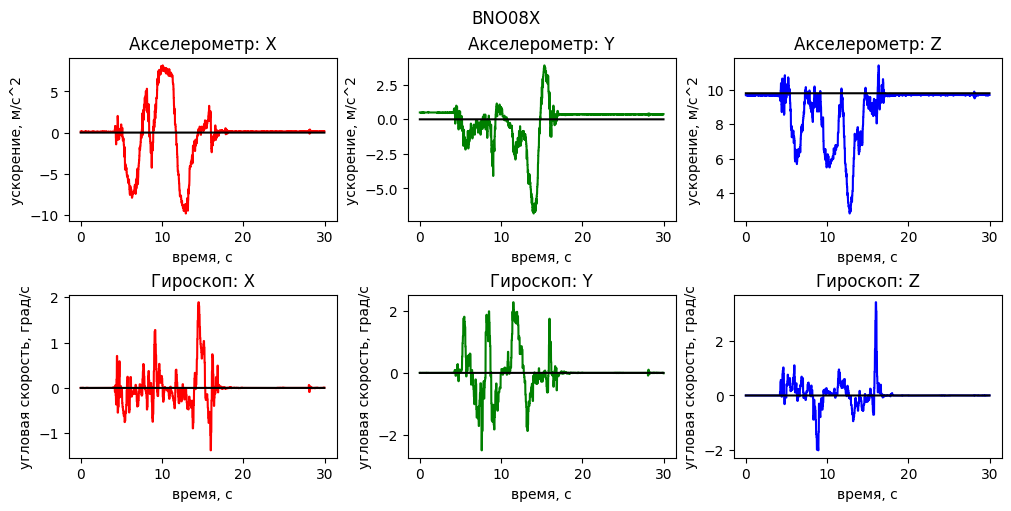

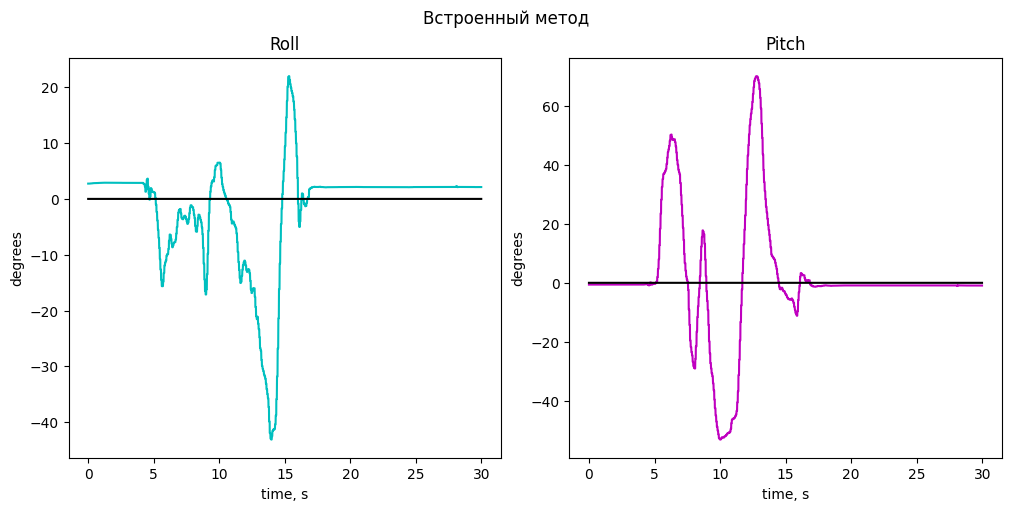

Avg roll:  -1.78626
Std roll:  9.90775 

Avg pitch:  1.67542
Std pitch:  20.96839 



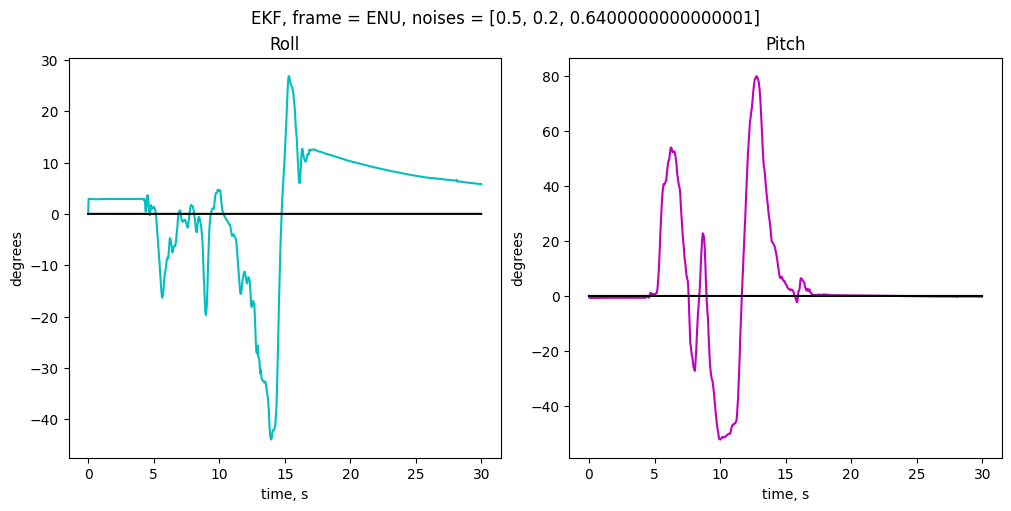

Avg roll:  1.44414
Std roll:  12.07565 

Avg pitch:  3.99021
Std pitch:  22.63814 



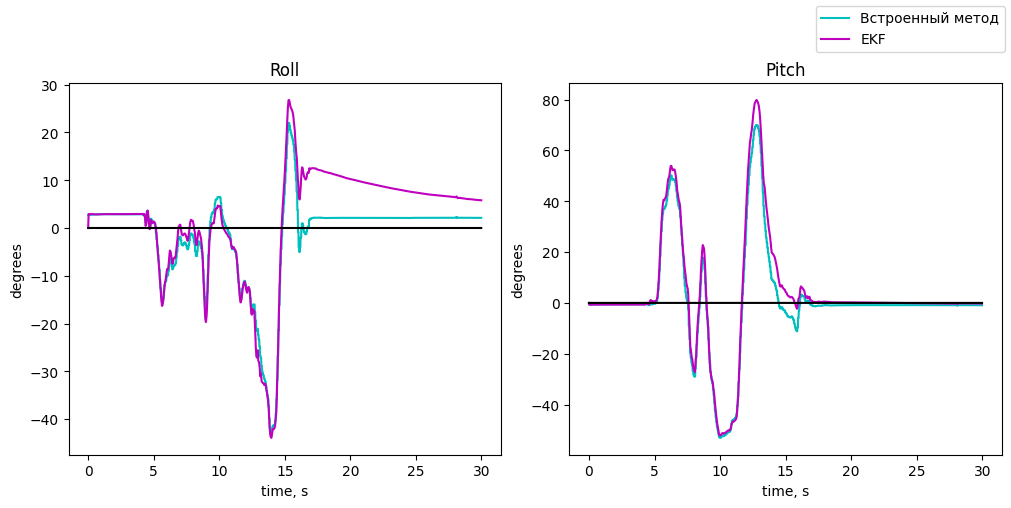

In [29]:
process_data(dat, "BNO08X", dat_bltin=dat_, apply_algs=[apply_ekf])